# Checking best models using score

In [1]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import emcee

In [2]:
# Load the intensity profile data
intensity_tot = np.load("../profiles/dens_test.npy")
print(intensity_tot.shape)

(233, 256, 256)


In [3]:
# Range 0 to 233
start = 0
end = 70

In [4]:
# Functions
def model_powerlaw(r, I0, gamma, r_g, sigma, f):
    R_cutL = 0.4
    R_cutR = 3.0

    powerlaw = I0 * ((r / r_g)**(-gamma))
    L_cut_factor = (r >= R_cutL).astype(float)
    R_cut_factor = (r <= R_cutR).astype(float)

    return powerlaw * L_cut_factor * R_cut_factor


def model_no_sinc(r, I0, gamma, r_g, sigma, f):
    R_cutL = 0.4
    R_cutR = 3.0
    powerlaw = I0 * ((r / r_g)**(-gamma))
    gauss = np.exp((-(r - r_g)**4) / (2 * sigma**4))
    L_cut_factor = (r >= R_cutL).astype(float)
    R_cut_factor = (r <= R_cutR).astype(float)

    gap_factor = (1 - f * (gauss))

    return powerlaw * gap_factor * L_cut_factor * R_cut_factor


def model_full(r, I0, gamma, r_g, sigma, f):
    c = 0.3
    R_cutL = 0.4
    R_cutR = 3.0

    r_sinc = c * (np.pi * ((r - r_g) / sigma))**2

    powerlaw = I0 * ((r / r_g)**(-gamma))
    sinc = np.sin(r_sinc) / r_sinc
    gauss = np.exp((-(r - r_g)**4) / (2 * sigma**4))
    L_cut_factor = (r >= R_cutL).astype(float)
    R_cut_factor = (r <= R_cutR).astype(float)

    gap_factor = (1 - f * (sinc * gauss))

    return powerlaw * gap_factor * L_cut_factor * R_cut_factor


def log_prior(parameters):
    I0, gamma, r_g, sigma, f = parameters
    if 0.1 < I0 < 1.5 and 0.1 < gamma < 1.2 and 0.8 < r_g < 1.2 and 0.01 < sigma < 0.8 and 0.1 < f < 1.0:
        return 0.0
    return -np.inf


def log_likelihood(parameters, r, data, error, model_func):
    model_profile = model_func(r, *parameters)
    return -0.5 * np.sum(((data - model_profile) / error)**2)


def log_probability(parameters, r, data, error, model_func):
    lp = log_prior(parameters)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(parameters, r, data, error, model_func)


def compute_fit_score(r, data, error, theta_best, model_func):
    I_model = model_func(r, *theta_best)
    residuals = (data - I_model) / error
    chi2_red = np.mean(residuals**2)
    score = 1 / (1 + chi2_red)
    return score


In [5]:
# Setup
r = np.linspace(0.1, 3, 300)
models = {
    "powerlaw": model_powerlaw,
    "no_sinc": model_no_sinc,
    "full": model_full,
}
model_scores = {model_name: [] for model_name in models}
steps = 10000
steps_discarded = 2500
initial = np.array([1.0, 1.0, 1.0, 0.1, 0.5])
ndim = len(initial)
nwalkers = 10
initial_position = initial + 1e-3 * np.random.randn(nwalkers, ndim)

In [6]:
for i in range(start, end):
    img = (np.load("../profiles/dens_test.npy"))[i]
    print(f"Processing profile {i + 1} of {end - start + 1}")

    ny, nx = img.shape
    x = np.linspace(-3, 3, nx)
    y = np.linspace(-3, 3, ny)
    xx, yy = np.meshgrid(x, y)
    theta_i = np.linspace(-np.pi, np.pi, 360)
    rr, tt = np.meshgrid(r, theta_i)
    xi = rr * np.cos(tt)
    yi = rr * np.sin(tt)
    points = np.vstack((xx.flatten(), yy.flatten())).T
    values = img.flatten()
    grid_intensity = griddata(points, values, (xi, yi), fill_value=0)

    simulation_profile = np.mean(grid_intensity, axis=0)
    simulation_error = np.std(grid_intensity, axis=0)
    simulation_error[simulation_error < 1e-8] = 1e-8

    for name, model_func in models.items():
        args = (r, simulation_profile, simulation_error, model_func)
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=args)
        sampler.run_mcmc(initial_position, steps, progress=True)
        flat_samples = sampler.get_chain(discard=steps_discarded, thin=20, flat=True)
        theta_best = np.median(flat_samples, axis=0)
        score = compute_fit_score(r, simulation_profile, simulation_error, theta_best, model_func)
        model_scores[name].append(score)

Processing profile 1 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1265.84it/s]


Processing profile 2 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1135.17it/s]


Processing profile 3 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1370.70it/s]


Processing profile 4 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1317.51it/s]


Processing profile 5 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1157.46it/s]


Processing profile 6 of 70


100%|██████████| 10000/10000 [00:10<00:00, 941.14it/s]


Processing profile 7 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1140.42it/s]


Processing profile 8 of 70


100%|██████████| 10000/10000 [00:09<00:00, 1093.30it/s]


Processing profile 9 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1160.07it/s]


Processing profile 10 of 70


100%|██████████| 10000/10000 [00:09<00:00, 1088.80it/s]


Processing profile 11 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1149.86it/s]


Processing profile 12 of 70


100%|██████████| 10000/10000 [00:09<00:00, 1107.15it/s]


Processing profile 13 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1163.93it/s]


Processing profile 14 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1120.34it/s]


Processing profile 15 of 70


100%|██████████| 10000/10000 [00:09<00:00, 1078.85it/s]


Processing profile 16 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1182.33it/s]


Processing profile 17 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1159.56it/s]


Processing profile 18 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1114.66it/s]


Processing profile 19 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1143.96it/s]


Processing profile 20 of 70


100%|██████████| 10000/10000 [00:09<00:00, 1056.80it/s]


Processing profile 21 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1232.93it/s]


Processing profile 22 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1233.76it/s]


Processing profile 23 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1307.02it/s]


Processing profile 24 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1284.33it/s]


Processing profile 25 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1267.25it/s]


Processing profile 26 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1239.61it/s]


Processing profile 27 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1255.99it/s]


Processing profile 28 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1252.90it/s]


Processing profile 29 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1281.59it/s]


Processing profile 30 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1187.87it/s]


Processing profile 31 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1304.21it/s]


Processing profile 32 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1118.47it/s]


Processing profile 33 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1225.54it/s]


Processing profile 34 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1193.76it/s]


Processing profile 35 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1208.13it/s]


Processing profile 36 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1224.08it/s]


Processing profile 37 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1195.59it/s]


Processing profile 38 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1170.04it/s]


Processing profile 39 of 70


100%|██████████| 10000/10000 [00:09<00:00, 1054.38it/s]


Processing profile 40 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1215.24it/s]


Processing profile 41 of 70


100%|██████████| 10000/10000 [00:09<00:00, 1063.66it/s]


Processing profile 42 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1194.68it/s]


Processing profile 43 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1178.45it/s]


Processing profile 44 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1419.67it/s]


Processing profile 45 of 70


100%|██████████| 10000/10000 [00:09<00:00, 1098.20it/s]


Processing profile 46 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1287.33it/s]


Processing profile 47 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1214.36it/s]


Processing profile 48 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1184.97it/s]


Processing profile 49 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1189.68it/s]


Processing profile 50 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1239.63it/s]


Processing profile 51 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1198.07it/s]


Processing profile 52 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1275.49it/s]


Processing profile 53 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1285.86it/s]


Processing profile 54 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1286.37it/s]


Processing profile 55 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1363.08it/s]


Processing profile 56 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1300.92it/s]


Processing profile 57 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1313.92it/s]


Processing profile 58 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1342.76it/s]


Processing profile 59 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1225.19it/s]


Processing profile 60 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1250.22it/s]


Processing profile 61 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1293.21it/s]


Processing profile 62 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1314.98it/s]


Processing profile 63 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1340.17it/s]


Processing profile 64 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1312.39it/s]


Processing profile 65 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1283.58it/s]


Processing profile 66 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1256.00it/s]


Processing profile 67 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1287.21it/s]


Processing profile 68 of 70


100%|██████████| 10000/10000 [00:08<00:00, 1200.22it/s]


Processing profile 69 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1327.78it/s]


Processing profile 70 of 70


100%|██████████| 10000/10000 [00:07<00:00, 1342.84it/s]


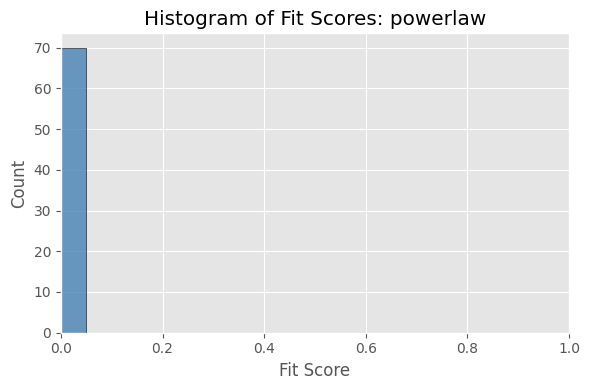

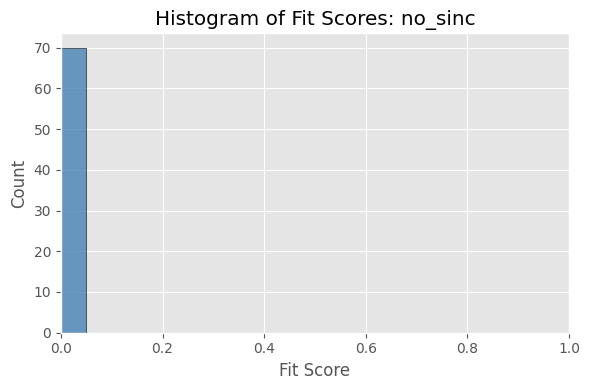

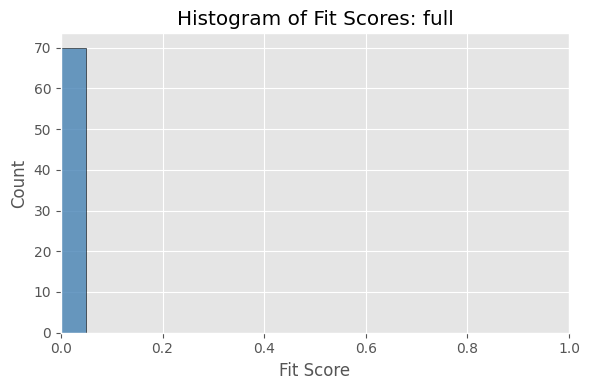

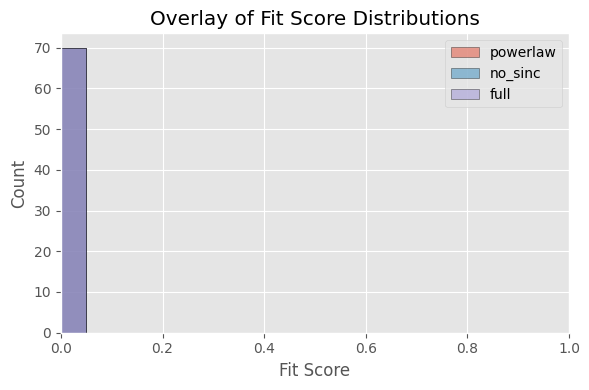

In [7]:
# Set figure size and style
plt.style.use("ggplot")

# Individual histograms
for model_name in models:
    plt.figure(figsize=(6, 4))
    plt.hist(model_scores[model_name], bins=20, range=(0, 1),
             color="steelblue", edgecolor="black", alpha=0.8)
    plt.title(f"Histogram of Fit Scores: {model_name}")
    plt.xlabel("Fit Score")
    plt.ylabel("Count")
    plt.xlim(0, 1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Overlay plot
plt.figure(figsize=(6, 4))
for model_name in models:
    plt.hist(model_scores[model_name], bins=20, range=(0, 1),
             alpha=0.5, label=model_name, edgecolor="black")
plt.title("Overlay of Fit Score Distributions")
plt.xlabel("Fit Score")
plt.ylabel("Count")
plt.xlim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
